<a href="https://colab.research.google.com/github/PGM-Lab/2023-probai-private/blob/main/python/Day2-AfterLunch/notebooks/BayesianNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Neural Networks

Neural networks are powerful approximators. However, standard approaches for learning this approximators does not take into account the inherent uncertainty we may have when fitting a model.

In [1]:
%pip install -q numpy pyro-ppl torch matplotlib
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import pyro

Note: you may need to restart the kernel to use updated packages.


/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

We use some fake data. As neural nets of even one hidden layer
can be universal function approximators, we can see if we can
train a simple neural network to fit a noisy sinusoidal data, like this:


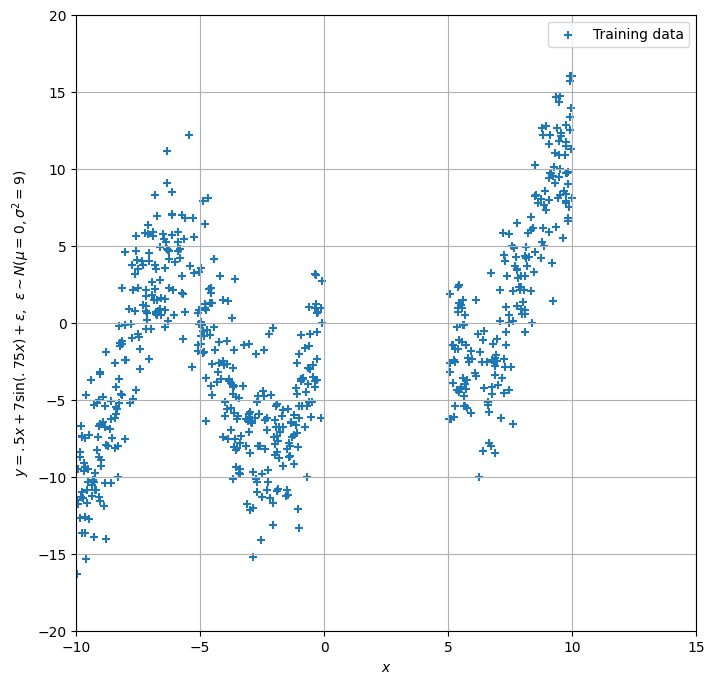

In [2]:
torch.manual_seed(42)
np.random.seed(42)

# Create the data
def gold_standard(x):
    return .5 * x + 7. * np.sin(0.75 * x)

NSAMPLE = 600
x_train = np.concatenate(
    (np.random.uniform(-10, 0, ((2 * NSAMPLE)//3, 1)),np.random.uniform(5, 10, (NSAMPLE - (2 * NSAMPLE)//3, 1))),
    axis=0)
y_train = gold_standard(x_train) + np.random.normal(size=(NSAMPLE,1), scale=3.0)
x_test = np.arange(-20, 15, 0.05).reshape(-1,1)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

# Plot it. Notice the gap in observations
plt.figure(figsize=(8, 8))
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.xlabel("$x$")
plt.ylabel("$y = .5x + 7\\sin(.75x) + \\epsilon$,  " + 
           "$\\epsilon\\sim N (\\mu=0, \\sigma^2=9)$")
plt.xlim([-10, 15])
plt.ylim([-20, 20])
plt.grid(True, "both")
plt.legend()

## Training a neural network

We employ a simple feedforward network with `NHIDDEN` hidden units to try to fit the data.

<center>
<img src="./BNNs-plain.png" alt="Drawing" height="250">
</center>



In [3]:
class NeuralNetwork():
    def __init__(self, NHIDDEN):
        # Simple random initialization close to zero
        self.w = torch.nn.Parameter(torch.randn(1, NHIDDEN) * 0.05)
        self.b = torch.nn.Parameter(torch.randn(1, NHIDDEN) * 0.05)
        self.w_out = torch.nn.Parameter(torch.randn(NHIDDEN,1) * 0.05)
        self.b_out = torch.nn.Parameter(torch.randn(1, 1) * 0.05)

    def params(self):
        return {"b":self.b, "w": self.w, "b_out":self.b_out, "w_out": self.w_out}

    def predict(self, x_data):
        hidden_layer = torch.nn.Tanh()(torch.mm(x_data, self.w) + self.b)
        return torch.matmul(hidden_layer, self.w_out) + self.b_out

NHIDDEN = 250
neuralNetwork = NeuralNetwork(NHIDDEN)

loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(neuralNetwork.params().values(), lr=0.01)
num_iterations = 10000

for j in range(num_iterations + 1):
    # run the model forward on the data
    y_pred = neuralNetwork.predict(x_train)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_train)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    if j % 1000 == 0:
        print("[iteration %05d] loss: %12.2f" % (j, loss.item()))

[iteration 00000] loss:     26396.45
[iteration 01000] loss:      5085.80
[iteration 02000] loss:      5049.85
[iteration 03000] loss:      5030.62
[iteration 04000] loss:      5016.68
[iteration 05000] loss:      5009.85
[iteration 06000] loss:      5005.26
[iteration 07000] loss:      4999.36
[iteration 08000] loss:      4999.06
[iteration 09000] loss:      4982.93
[iteration 10000] loss:      4965.25


### Results:
We see that the neural network can fit this sinusoidal data quite well, as expected. However, notice the behavour around the gap in the data. 

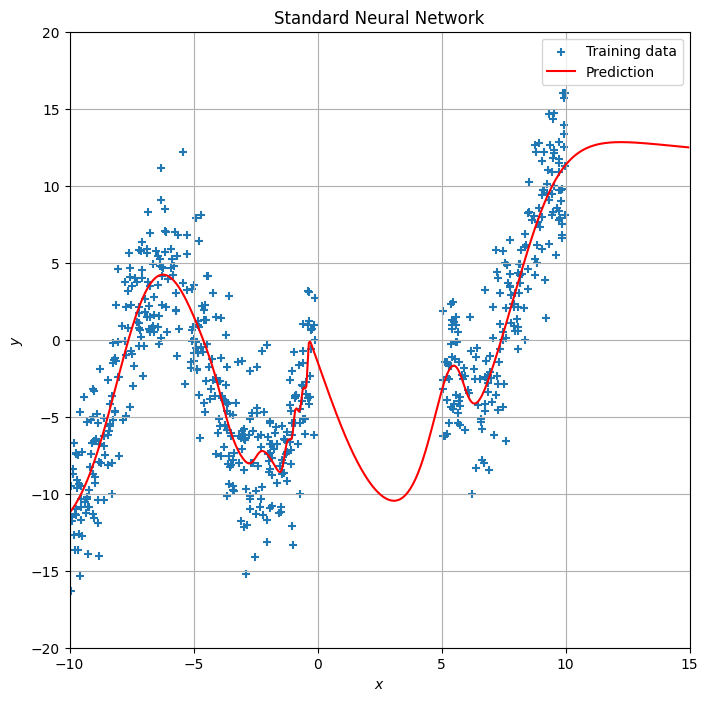

In [4]:
y_test = neuralNetwork.predict(x_test.clone()).detach()

plt.figure(figsize=(8, 8))
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.plot(x_test, y_test, 'r-', label='Prediction');
plt.title('Standard Neural Network')
plt.legend();
plt.xticks(np.arange(-10, 16, 5))
plt.yticks(np.arange(-20, 21, 5))
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim([-10, 15])
plt.ylim([-20, 20])
plt.grid(True, "both")

However this model is unable to capture the uncertainty in the model. For example, when making predictions about a single point (e.g. around $x=2.5$) we can see we do not account aobut the inherent noise there is in this predictions or the uncertainty about what the model shouyld actually be in this area. In next section, we will what happen when we introduce a Bayesian approach using

## Bayesian Learning of Neural Networks

[Bayesian modeling](https://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a distribution over models that are consistent with the observed data.

In Bayesian learning, the weights of the network are **random variables**. The output of the nework is also a **random variable**. The random variable of the output *implicitly defines the loss function*. So, when making Bayesian learning we do **not** define *loss functions*, we do define *random variables*, and fit calculate their *posterior* distributions.

<center>
<img src="./BNNs-prob.png" alt="Drawing" height="250">
</center>


In [5]:
def model(NHIDDEN, x_train, y_train):
    # The Bayesian NN has random variables representing what was torch.nn.Parameter-s in the standard neural net.
    W = pyro.sample("W", pyro.distributions.Normal(loc = torch.zeros([1, NHIDDEN]), scale=1.).to_event())
    b = pyro.sample("b", pyro.distributions.Normal(loc = torch.zeros([1, NHIDDEN]), scale=1.).to_event())
    W_out = pyro.sample("W_out", pyro.distributions.Normal(loc = torch.zeros([NHIDDEN,1]), scale=1.).to_event())
    b_out = pyro.sample("b_out", pyro.distributions.Normal(loc = torch.zeros([1,1]), scale=1.).to_event())

    # The model definition includes what we had in the .predict - method above 
    hidden_layer = torch.nn.Tanh()(torch.mm(x_train, W) + b)
    out =  torch.matmul(hidden_layer,W_out) + b_out

    # We want the model (given a value for all random variables defining weights and biases) to model a random variable. 
    # We do that by defining it as a Gaussian with mean given by the model's output, and fixed standfard dev 1.
    predictive_mean = pyro.deterministic("predictive_mean", out)
    with pyro.plate("data", x_train.shape[0]):
        y = pyro.sample("y", pyro.distributions.Normal(loc=predictive_mean, scale=1.).to_event(1), obs=y_train)

The learning is done by [Pyro](https://pyro.ai). We get access to `SVI`, a class that does the variational inference for us using the `guide`, which defines the set of variational approximations $\mathcal{Q}$. We will disregard the details of this for now...

In [6]:
# Setup the optimizer. Never mind the details here, it is internal to Pyro
pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoNormal(model)
svi = pyro.infer.SVI(model=model, guide=guide, loss=pyro.infer.Trace_ELBO(), optim=pyro.optim.Adam({"lr": 0.01}), )

# Training loop
for epoch in range(num_iterations + 1):
    loss = svi.step(NHIDDEN, x_train, y_train)
    if (epoch % 500) == 0:
        print("[epoch %05d] ELBO: %12.2f" % (epoch, -loss))

[epoch 00000] ELBO:    -14357.77
[epoch 00500] ELBO:     -9168.38
[epoch 01000] ELBO:     -5487.45
[epoch 01500] ELBO:     -5096.64
[epoch 02000] ELBO:     -4814.59
[epoch 02500] ELBO:     -4920.99
[epoch 03000] ELBO:     -4882.66
[epoch 03500] ELBO:     -4628.85
[epoch 04000] ELBO:     -4542.73
[epoch 04500] ELBO:     -4581.15
[epoch 05000] ELBO:     -4648.40
[epoch 05500] ELBO:     -4531.78
[epoch 06000] ELBO:     -4931.69
[epoch 06500] ELBO:     -5241.81
[epoch 07000] ELBO:     -4386.83
[epoch 07500] ELBO:     -4562.50
[epoch 08000] ELBO:     -4398.37
[epoch 08500] ELBO:     -4849.09
[epoch 09000] ELBO:     -4424.09
[epoch 09500] ELBO:     -4405.40
[epoch 10000] ELBO:     -4349.37


### Benefit: Explicit representation of uncertainty
As can be seen in the next figure, the output of our model is no longer deterministic. Instead, we now caputure our uncertainty and make it explicit. Notice how we capture both epistemic ("model-uncertainty") and aleatoric ("data randomness") uncertainty. Consider in particular what happens with the predictions where we did not have training-data (around $x=2.5$ and for $x>10$). 

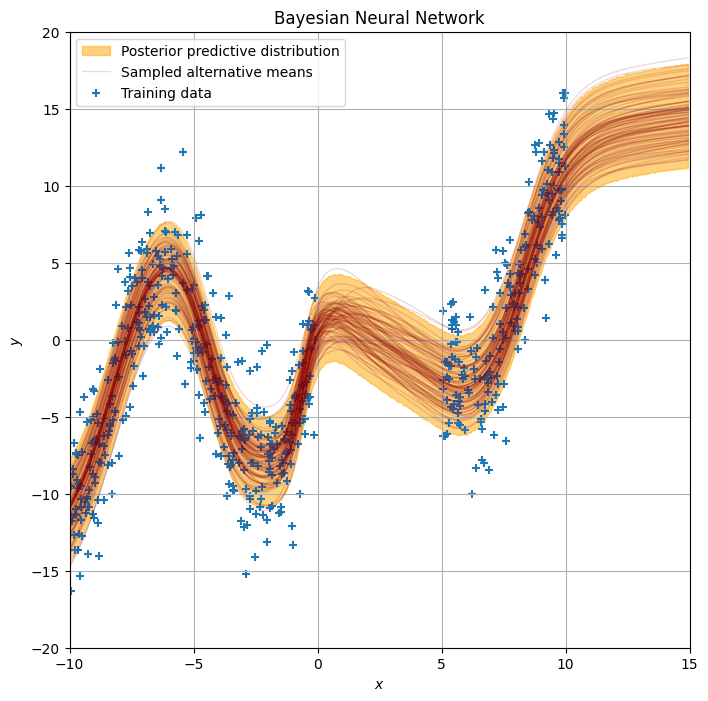

In [7]:
# Run model to generate samples. Each sample means all weights are sampled 
# from their posterior distributions. 
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=5000)
svi_samples = predictive(NHIDDEN, x_test, None)

# Calculate per-x sample-mean and sample-std to show uncertainty bounds
y_preds = torch.squeeze(svi_samples['y']).detach().numpy()
y_mean = np.mean(y_preds, axis=0)
y_sigma = np.std(y_preds, axis=0)
plt.figure(figsize=(8, 8))
plt.fill_between(x_test.ravel(), 
                 y_mean + 2 * y_sigma, y_mean - 2 * y_sigma, alpha=0.5, 
                 color='orange', 
                 label = "Posterior predictive distribution")

# Calculate the predictive mean. Note that we get one per mean-line sample of model weights, 
# hence we are able to expose model uncertainty. 
y_predictive_mean = torch.squeeze(svi_samples['predictive_mean']).detach().numpy()
for i in range(np.min([100, y_predictive_mean.shape[0]])):
      plt.plot(x_test, y_predictive_mean[i], color='darkred', linewidth=1, alpha=.15, label="Sampled alternative means" if not i else None)
plt.scatter(x_train, y_train, marker='+', label = "Training data")

# Make the plot look good
plt.xticks(np.arange(-10, 16, 5))
plt.yticks(np.arange(-20, 21, 5))
plt.title('Bayesian Neural Network')
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim([-10, 15])
plt.ylim([-20, 20])
plt.grid(True, "both")

### <span style="color:red">Optional</span> exercise:  Fix the variance

If you want to dig more into this in your own time, then consider the variance of the variable $y$ in the above model. It was assumed fixed at $\sigma=1$ (a pooor choice since $\sigma=3$ was used when we sampled the data) when we said that
``y = pyro.sample("y", pyro.distributions.Normal(loc=predictive_mean, scale=1.).to_event(1), obs=y_train)``.

There are several ways to improve on this (beyond "cheating" and hardcoding that $\sigma=3$):

1. Introduce a Pyro parameter to learn the variance. **Hint:** Initialize with a very small value.

2. Introduce a Pryro random variable to represent the variance, and find its posterior. **Hint:** Initialize the guide's random variable with a very small value.

3. Make the variance dependent of the input data by learning a model that outputs $\log\sigma$ as a function of $x$.


Evaluate the output for all cases and compare with the previous results.
